In [1]:
import os, sys
import logging
import tensorflow as tf
import datetime
from model import ST_ResNet
from preprocessing.BatchGenerator import batch_generator
from preprocessing.TaxiBJ import load_data

In [2]:
### system and log setting ###
logging.basicConfig(level=logging.DEBUG, format=' %(levelname)s - %(message)s')
# log_dir = os.path.join("train_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
model_path = os.path.join("model_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

### model hyperparameters ###
nb_epoch = 50  # number of epoch
batch_size = 32  # batch size
T = 48  # number of time intervals in one day
len_closeness = 3  # length of closeness dependent sequence
len_period = 3  # length of  period dependent sequence
len_trend = 3  # length of trend dependent sequence
days_test = 7 * 4 # number of days for test
len_test = T * days_test # number of time intervals for test
map_height, map_width = 32, 32 # resolution of map
nb_flow = 2 # number of map channel or in-out flows
lr = 0.001 # learning rate
nb_filters = 64 # number of filters in CNN (except conv2)
nb_residual_unit = 12 # number of residual unit
batchnorm = True # whether perform batch normalization in ResUnit

In [3]:
# convert original data to sequencial data for each available time point
# perform minmax normalization, merging external variables, train-test split
X_train, Y_train, X_test, Y_test, mmn, external_dim, timestamp_train, timestamp_test = \
    load_data(len_closeness=len_closeness, len_period=len_period, len_trend=len_trend, len_test=len_test)

load /Users/yueli/Desktop/PhD/research/data/TaxiBJ/CACHE/TaxiBJ_C3_P3_T3.h5 successfully


In [ ]:
print(X_train[0].shape)
print(X_train[1].shape)
print(X_train[2].shape)
print(X_train[3].shape)
print(Y_train.shape)
print(X_test[0].shape)
print(X_test[1].shape)
print(X_test[2].shape)
print(X_test[3].shape)
print(Y_test.shape)
print(external_dim)
print(len(timestamp_train))
print(len(timestamp_test))

(6528, 32, 32, 6)
(6528, 32, 32, 6)
(6528, 32, 32, 6)
(6528, 28)
(6528, 32, 32, 2)
(1344, 32, 32, 6)
(1344, 32, 32, 6)
(1344, 32, 32, 6)
(1344, 28)
(1344, 32, 32, 2)
28
6528
1344


In [5]:
# obtain an iterator for the next batch
train_batch_generator = batch_generator(X_train, Y_train, batch_size)
test_batch_generator = batch_generator(X_test, Y_test, batch_size)

In [6]:
# create an instance of the graph object
g = ST_ResNet(lr=lr,nb_filters=nb_filters,nb_flow=nb_flow,nb_residual_unit=nb_residual_unit,batchnorm=batchnorm)

# invoke the forward pass to specify the input shape
closeness_shape = (1, map_height, map_width, len_closeness * nb_flow)
period_shape = (1, map_height, map_width, len_period * nb_flow)
trend_shape = (1, map_height, map_width, len_trend * nb_flow)
ext_shape = (1, external_dim)

dummy_closeness = tf.random.normal(closeness_shape)
dummy_period = tf.random.normal(period_shape)
dummy_trend = tf.random.normal(trend_shape)
dummy_ext = tf.random.normal(ext_shape)

dummy_output = g(dummy_closeness, dummy_period, dummy_trend, dummy_ext)

In [ ]:
RMSE = []

In [7]:
for epoch in range(nb_epoch):
    
    print("Epoch: {}\t".format(epoch), )
    
    # training
    num_batches = X_train[0].shape[0] // batch_size
    for b in range(num_batches):
        x_batch, y_batch = next(train_batch_generator)
        x_closeness = x_batch[0]
        x_period = x_batch[1]
        x_trend = x_batch[2]
        x_ext = x_batch[3]
        g.train_step(((x_closeness, x_period, x_trend, x_ext), y_batch))
        
        #with tf.summary.create_file_writer(log_dir + '/train').as_default():
        #    tf.summary.scalar('loss', loss_tr, step=epoch * num_batches + b)
    
    MSE_train = g.train_loss_logger.result()
    g.train_loss_logger.reset_states()
    
    # testing
    num_batches = X_test[0].shape[0] // batch_size
    for b in range(num_batches):
        x_batch, y_batch = next(test_batch_generator)
        x_closeness = x_batch[0]
        x_period = x_batch[1]
        x_trend = x_batch[2]
        x_ext = x_batch[3]
        result = g.test_step(((x_closeness, x_period, x_trend, x_ext), y_batch), mmn)

        #with tf.summary.create_file_writer(log_dir + '/val').as_default():
        #    tf.summary.scalar('loss', loss_t, step=epoch * num_batches + b)
    
    RMSE_test = tf.math.sqrt(g.test_loss_logger.result())
    g.test_loss_logger.reset_states()
    
    print("MSE_train: {:.5f}, RMSE_test: {:.5f}".format(MSE_train, RMSE_test))
    RMSE.append(RMSE_test)
    
    # Save the model after every epoch
    g.save(model_path)
    

Epoch: 0	


2023-04-08 12:25:47.522248: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Cause: Unable to locate the source code of <bound method MinMaxNormalization.inverse_transform of <preprocessing.MinMaxNormalization.MinMaxNormalization object at 0x106378220>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


 WARNING - AutoGraph could not transform <bound method MinMaxNormalization.inverse_transform of <preprocessing.MinMaxNormalization.MinMaxNormalization object at 0x106378220>> and will run it as-is.
Cause: Unable to locate the source code of <bound method MinMaxNormalization.inverse_transform of <preprocessing.MinMaxNormalization.MinMaxNormalization object at 0x106378220>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <bound method MinMaxNormalization.inverse_transform of <preprocessing.MinMaxNormalization.MinMaxNormalization object at 0x106378220>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
MSE_train: 0.10941, RMSE_test: 45.37596
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(sha

 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 1	
MSE_train: 0.00360, RMSE_test: 39.62339
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 2	
MSE_train: 0.00250, RMSE_test: 32.93599
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 3	
MSE_train: 0.00201, RMSE_test: 29.87171
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 4	
MSE_train: 0.00175, RMSE_test: 28.61286
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 5	
MSE_train: 0.00159, RMSE_test: 27.49276
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 6	
MSE_train: 0.00146, RMSE_test: 26.61662
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 7	
MSE_train: 0.00137, RMSE_test: 26.18781
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 8	
MSE_train: 0.00130, RMSE_test: 25.37658
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 9	
MSE_train: 0.00126, RMSE_test: 24.98054
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 10	
MSE_train: 0.00120, RMSE_test: 25.10297
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 11	
MSE_train: 0.00116, RMSE_test: 24.66799
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 12	
MSE_train: 0.00112, RMSE_test: 24.70558
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 13	
MSE_train: 0.00109, RMSE_test: 23.91130
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 14	
MSE_train: 0.00106, RMSE_test: 24.21766
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 15	
MSE_train: 0.00104, RMSE_test: 23.92117
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 16	
MSE_train: 0.00105, RMSE_test: 23.46753
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 17	
MSE_train: 0.00101, RMSE_test: 22.98141
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 18	
MSE_train: 0.00101, RMSE_test: 22.71608
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 19	
MSE_train: 0.00103, RMSE_test: 23.57025
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 20	
MSE_train: 0.00098, RMSE_test: 22.70678
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 21	
MSE_train: 0.00094, RMSE_test: 22.66319
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 22	
MSE_train: 0.00093, RMSE_test: 22.23293
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 23	
MSE_train: 0.00092, RMSE_test: 22.19529
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 24	
MSE_train: 0.00096, RMSE_test: 23.21061
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 25	
MSE_train: 0.00091, RMSE_test: 21.86082
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 26	
MSE_train: 0.00088, RMSE_test: 22.00842
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 27	
MSE_train: 0.00087, RMSE_test: 22.39951
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 28	
MSE_train: 0.00087, RMSE_test: 21.79410
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 29	
MSE_train: 0.00084, RMSE_test: 21.40086
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 30	
MSE_train: 0.00088, RMSE_test: 22.32088
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 31	
MSE_train: 0.00088, RMSE_test: 22.31310
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 32	
MSE_train: 0.00083, RMSE_test: 22.24478
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 33	
MSE_train: 0.00082, RMSE_test: 21.54579
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 34	
MSE_train: 0.00084, RMSE_test: 21.26977
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 35	
MSE_train: 0.00084, RMSE_test: 20.94550
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 36	
MSE_train: 0.00079, RMSE_test: 22.30033
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 37	
MSE_train: 0.00080, RMSE_test: 21.29138
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 38	
MSE_train: 0.00082, RMSE_test: 21.68495
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 39	
MSE_train: 0.00080, RMSE_test: 21.81368
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 40	
MSE_train: 0.00079, RMSE_test: 20.88240
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 41	
MSE_train: 0.00081, RMSE_test: 25.00120
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 42	
MSE_train: 0.00080, RMSE_test: 21.63467
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 43	
MSE_train: 0.00077, RMSE_test: 20.47792
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 44	
MSE_train: 0.00077, RMSE_test: 21.34190
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 45	
MSE_train: 0.00084, RMSE_test: 22.94000
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 46	
MSE_train: 0.00081, RMSE_test: 20.51975
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 47	
MSE_train: 0.00076, RMSE_test: 20.19635
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 48	
MSE_train: 0.00076, RMSE_test: 20.63125
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


Epoch: 49	
MSE_train: 0.00078, RMSE_test: 20.84970
INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


INFO:tensorflow:Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).


 INFO - Unsupported signature for serialization: ((((TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/0'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/1'), TensorSpec(shape=(32, 32, 32, 6), dtype=tf.float64, name='data/0/2'), TensorSpec(shape=(32, 28), dtype=tf.float64, name='data/0/3')), TensorSpec(shape=(32, 32, 32, 2), dtype=tf.float64, name='data/1')), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x148f1c520>), {}).
 WARNING - Found untraced functions such as test_step, conv2d_layer_call_fn, conv2d_layer_call_and_return_conditional_losses, _jit_compiled_convolution_op, conv2d_25_layer_call_fn while saving (showing 5 of 455). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: model_logs/20230408-122535/assets


 INFO - Assets written to: model_logs/20230408-122535/assets


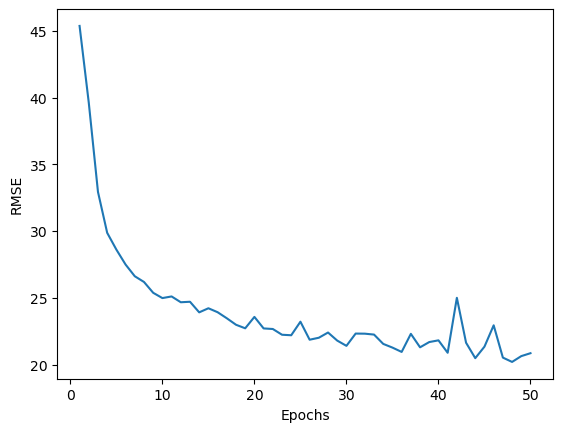

In [10]:
import matplotlib.pyplot as plt

mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

epochs = range(1, len(RMSE)+1)
plt.plot(epochs, RMSE)
plt.xlabel('Epochs')
plt.ylabel('RMSE')

plt.show()
